In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Reading the Weather and PM2.5 Data

- using min-max normalization

In [2]:
from data_preprocessing import load_X_y
import pandas as pd

weather_df, pollutant_df = load_X_y()

In [3]:
weather_df_normalized = (weather_df-weather_df.min())/(weather_df.max()-weather_df.min())
weather_df_normalized.describe()

,max_dew_point_v,max_relative_humidity_v,max_temperature_v,max_wind_speed_v,min_dew_point_v,min_relative_humidity_v,min_temperature_v,min_wind_speed_v,precipitation_v,rain_v,snow_v,snow_on_ground_v
count,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000
mean,0.514953,0.571856,0.524171,0.571205,0.518990,0.486371,0.519177,0.510449,0.491174,0.509921,0.247726,0.177910
std,0.335249,0.218783,0.335174,0.255798,0.326785,0.261585,0.314073,0.271372,0.181621,0.244698,0.315199,0.278788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.179659,0.412934,0.182859,0.357715,0.201610,0.258465,0.210211,0.271762,0.344340,0.237410,0.000000,0.000000
50%,0.495475,0.597683,0.536310,0.632265,0.500370,0.435290,0.517430,0.509554,0.504717,0.593525,0.016667,0.000000
75%,0.863534,0.743629,0.859094,0.795591,0.851591,0.731753,0.828169,0.762208,0.617925,0.701439,0.583333,0.360465
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
pollutant_df.describe()

,P2.5
count,7304.000000
mean,7.435753
std,5.374638
min,0.000000
25%,3.916667
50%,6.166667
75%,9.333333
max,58.666667


In [5]:
pollutant_tensor = torch.tensor(pollutant_df['P2.5'].values)
weather_tensor = torch.tensor(weather_df_normalized[:].values)

print(pollutant_tensor.shape)
print(weather_tensor.shape)

torch.Size([7304])
torch.Size([7304, 12])


In [6]:
type(pollutant_tensor)

torch.Tensor

# Dataset

- We'll train using the first 5000+14 days to train, 1000+14 days to validate, 1000+14 days to test
- Ensure sequencing is maintained
- Test data will be the latest data as the model is intended to use historical data to predict future data

In [7]:
from torch.utils.data import Dataset

In [8]:
# creating a custom dataset in a sliding window manner
class WeatherPollutantDataset(Dataset):
    def __init__(self, weather: torch.Tensor, pollutant: torch.Tensor, window:int):
        self.weather = weather
        self.pollutant = pollutant
        # assumes the data starts on the same day
        # assumes their length is the same
        assert len(self.weather) == len(self.pollutant)
        self.window = window

    def __getitem__(self, index: int):
        """
        Using weather input on day i,i+1,...,i+window-1 to predict pollutant output on i+window
        """
        weather_input = self.weather[index:index+self.window].permute(1,0)
        pollutant_output = self.pollutant[index+1:index+self.window+1]
        return weather_input, pollutant_output

    def __len__(self):
        return len(self.weather) - self.window

In [9]:
train_set = WeatherPollutantDataset(weather=weather_tensor[:5014], pollutant=pollutant_tensor[:5014], window=14)
val_set   = WeatherPollutantDataset(weather=weather_tensor[5014:6028], pollutant=pollutant_tensor[5014:6028], window=14)
test_set  = WeatherPollutantDataset(weather=weather_tensor[6028:7042], pollutant=pollutant_tensor[6028:7042], window=14)

In [10]:
print("Number of training data: %d" % len(train_set))
print("Number of validation data: %d" % len(val_set))
print("Number of testing data: %d" % len(test_set))

Number of training data: 5000
Number of validation data: 1000
Number of testing data: 1000


In [11]:
from torch.utils.data import DataLoader

In [12]:
test_loader = DataLoader(test_set, batch_size=64)
next(iter(test_loader))[0].shape

torch.Size([64, 12, 14])

# Model

In [13]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "CNNLSTM"
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm1d(num_features = 64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm1d(num_features = 64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm1d(num_features = 64)

        self.lstm = nn.LSTM(input_size=32*14, hidden_size=50, num_layers=3, batch_first=True)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 14)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 32*14)
        # x = x.squeeze(dim=2)
        x, _ = self.lstm(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
import matplotlib.pyplot as plt
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
          inputs = inputs.float().cuda()
          labels = labels.float().cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        total_epoch += len(labels)
    loss = float(total_loss) / (i + 1)
    return loss

def train_net(net, train_set, val_set, batch_size=64, learning_rate=0.002, num_epochs=30):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(train_set, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_set, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    net.train()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if torch.torch.cuda.is_available():
              inputs = inputs.float().cuda()
              labels = labels.float().cuda()
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            labels = labels.squeeze()
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            # Calculate the statistics
            total_train_loss += loss.item()
            # total_epoch += len(labels)
            total_epoch += 1
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train loss: {} | Validation loss: {}").format(epoch + 1,train_loss[epoch],val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        torch.save(net.state_dict(), 'ckpt/01112023_mse_batchsize_%d_learningrate_%d_epoch_%d'%(batch_size, learning_rate, 60+epoch))
    net.eval()
    print('Finished Training')
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    plt.title("Train loss")
    plt.plot(epochs, train_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.title("Validation loss")
    plt.plot(epochs, val_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


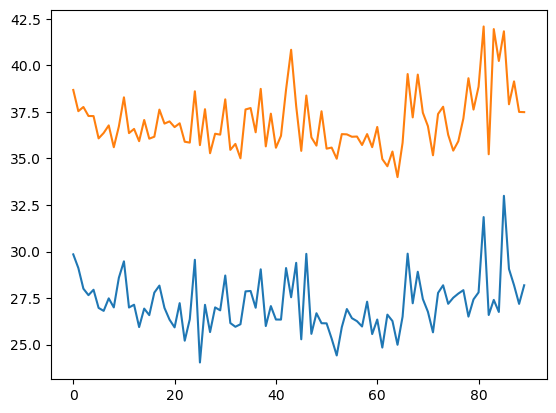

In [32]:
train_loss = []
val_loss = []
train_loader = torch.utils.data.DataLoader(train_set, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False)

for i in range(90):
    print(i)
    net = CNNLSTM()
    state = torch.load("ckpt/01112023_mse_batchsize_64_learningrate_0_epoch_%d" % i)
    net.load_state_dict(state)

    net.cuda()

    train_loss.append(evaluate(net, train_loader, nn.MSELoss()))
    val_loss.append(evaluate(net, val_loader, nn.MSELoss()))

epochs = list(range(90))
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)


In [33]:
train_loss_tensor = torch.tensor(train_loss)
val_loss_tensor = torch.tensor(val_loss)

torch.save(train_loss_tensor, 'train_loss.pt')
torch.save(val_loss_tensor, 'val_loss.pt')

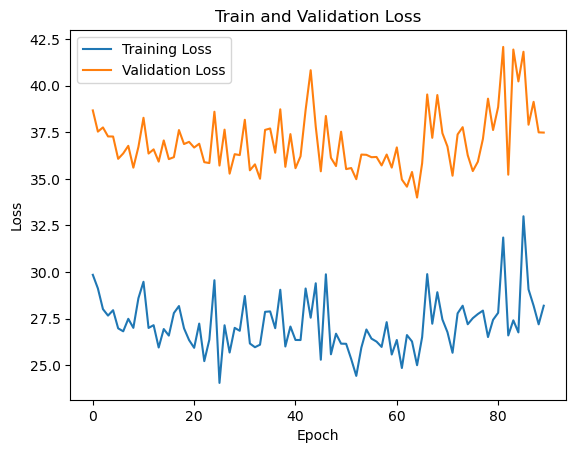

In [19]:
train_loss_tensor = torch.load('train_loss.pt')
val_loss_tensor = torch.load('val_loss.pt')

epochs = list(range(90))
plt.title("Train and Validation Loss")
plt.plot(epochs, train_loss_tensor, label='Training Loss')
plt.plot(epochs, val_loss_tensor, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [23]:
i = torch.argmin(val_loss_tensor)
print(val_loss_tensor[i])

tensor(33.9954)


In [20]:
net = CNNLSTM()
state = torch.load("ckpt/01112023_mse_batchsize_64_learningrate_0_epoch_59")
net.load_state_dict(state)
if torch.cuda.is_available():
    net.cuda()
train_net(net, train_set, val_set, batch_size=64, learning_rate=0.002, num_epochs=30)

KeyboardInterrupt: 

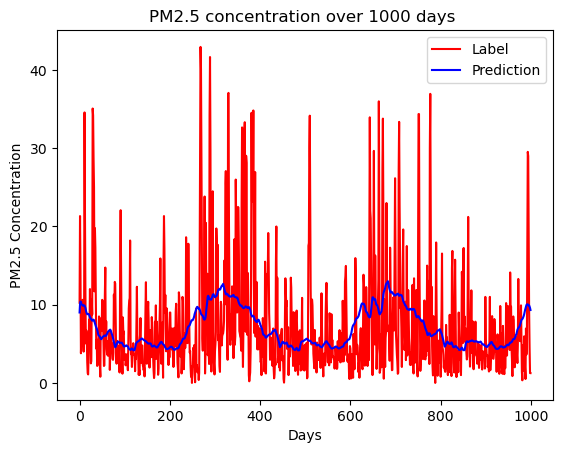

In [22]:
net = CNNLSTM()
state = torch.load("ckpt/01112023_mse_batchsize_64_learningrate_0_epoch_64")
net.load_state_dict(state)

net.cuda()

test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
data, label = next(iter(test_loader))
data = data.float().cuda()
pred = net(data)

t = range(1000)
plt.title("PM2.5 concentration over 1000 days ")
plt.plot(t, label.transpose(0,1)[0], 'r', label="Label")
plt.plot(t, pred.cpu().detach().numpy().transpose(0,1)[:,0], 'b', label='Prediction')
plt.xlabel("Days")
plt.ylabel("PM2.5 Concentration")
plt.legend(loc='best')
plt.show()